In [1]:
#hide
import sys #only for use to help with symlinks
sys.path.append("..")

In [1]:
from fastai.torch_core import set_seed
from fastai.vision.all import *
from fastai.medical.imaging import *
from torchvision.utils import save_image

from fmi.data import *
from fmi.core import *
from fmi.windows import *

In [2]:
source = 'D:/Datasets/Melanoma/'
files = os.listdir(source)
mel_items = get_dicom_files(source, folders='train')

In [3]:
source2 = 'D:/Datasets/osic-pulmonary-fibrosis-progression/'
os_items = get_dicom_files(source2, folders='train')
df_unique = pd.read_csv(f'{source2}/uniq.csv')
test1 = 'D:/Datasets/osic-pulmonary-fibrosis-progression/train/ID00009637202177434476278'
test_files = get_dicom_files(test1)

## Splits

In [4]:
def random_(items, value=500):
    randomList = []
    for i in range(0,value):
        randomList.append(random.randint(0,10000))
    return items[randomList]

In [5]:
random_(os_items, 100)

(#100) [Path('D:/Datasets/osic-pulmonary-fibrosis-progression/train/ID00042637202184406822975/74.dcm'),Path('D:/Datasets/osic-pulmonary-fibrosis-progression/train/ID00030637202181211009029/85.dcm'),Path('D:/Datasets/osic-pulmonary-fibrosis-progression/train/ID00038637202182690843176/196.dcm'),Path('D:/Datasets/osic-pulmonary-fibrosis-progression/train/ID00052637202186188008618/221.dcm'),Path('D:/Datasets/osic-pulmonary-fibrosis-progression/train/ID00009637202177434476278/204.dcm'),Path('D:/Datasets/osic-pulmonary-fibrosis-progression/train/ID00061637202188184085559/147.dcm'),Path('D:/Datasets/osic-pulmonary-fibrosis-progression/train/ID00077637202199102000916/16.dcm'),Path('D:/Datasets/osic-pulmonary-fibrosis-progression/train/ID00020637202178344345685/313.dcm'),Path('D:/Datasets/osic-pulmonary-fibrosis-progression/train/ID00027637202179689871102/283.dcm'),Path('D:/Datasets/osic-pulmonary-fibrosis-progression/train/ID00076637202199015035026/7.dcm')...]

In [6]:
check_duplicate(random_(mel_items, 100), seed=77)

Duplicate: set()


((#80) [17,80,74,39,54,27,23,7,69,44...],
 (#20) [55,4,90,14,47,22,64,13,96,65...])

## DataBlock

In [7]:
set_seed(7)
get_x1 = lambda x:f'{source2}/pct_window/{x.Patient}/{str(x.file)[2:-2]}'
get_y1 = ColReader('SmokingStatus')

blocks = (ImageBlock(cls=PEWindow), CategoryBlock)
db = DataBlock(blocks=blocks,
                   get_x=get_x1,
                   splitter=RandomSplitter(),
                   item_tfms=Resize(512),
                   get_y=get_y1,
                   batch_tfms=[IntToFloatTensor(div=255)])

In [8]:
db.summary(df_unique)

Setting-up type transforms pipelines
0             0  ID00007637202177411956430     -4  2315  58.253649   79  Male   
1             1  ID00009637202177434476278      8  3660  85.282878   69  Male   
2             2  ID00010637202177584971671      0  3523  94.724672   60  Male   
3             3  ID00011637202177653955184      6  3326  85.987590   72  Male   
4             4  ID00012637202177665765362     33  3418  93.726006   65  Male   
..          ...                        ...    ...   ...        ...  ...   ...   
171         171  ID00419637202311204720264      6  3020  70.186855   73  Male   
172         172  ID00421637202311550012437     15  2739  82.045291   68  Male   
173         173  ID00422637202311677017371      6  1930  76.672493   73  Male   
174         174  ID00423637202312137826377     17  3294  79.258903   72  Male   
175         175  ID00426637202313170790466      0  2925  71.824968   73  Male   

    SmokingStatus         file  
0       Ex-smoker   ['10.dcm']  
1    

In [9]:
db.batch_tfms

(#1) [IntToFloatTensor -- {'div': 255, 'div_mask': 1}:
encodes: (TensorImage,object) -> encodes
(TensorMask,object) -> encodes
decodes: (TensorImage,object) -> decodes
]

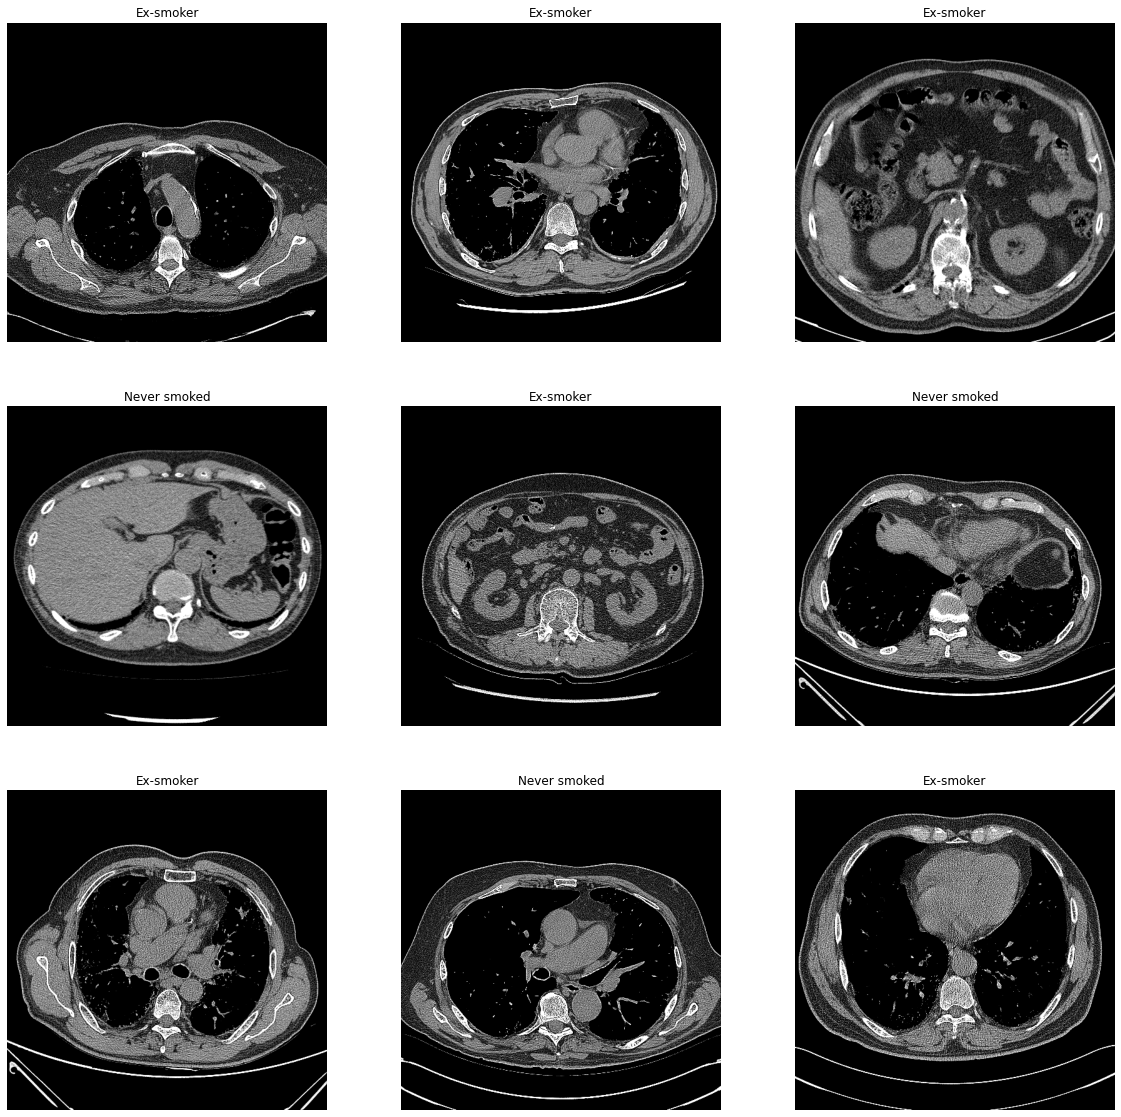

In [10]:
dls = db.dataloaders(df_unique, bs=16, n_workers=0)
dls.show_batch(figsize=(20,20))

## Sort

In [11]:
s = 'D:/Datasets/osic-pulmonary-fibrosis-progression/train/'
sort_items = get_dicom_files(s, folders='ID00007637202177411956430')
sort_items

(#30) [Path('D:/Datasets/osic-pulmonary-fibrosis-progression/train/ID00007637202177411956430/1.dcm'),Path('D:/Datasets/osic-pulmonary-fibrosis-progression/train/ID00007637202177411956430/10.dcm'),Path('D:/Datasets/osic-pulmonary-fibrosis-progression/train/ID00007637202177411956430/11.dcm'),Path('D:/Datasets/osic-pulmonary-fibrosis-progression/train/ID00007637202177411956430/12.dcm'),Path('D:/Datasets/osic-pulmonary-fibrosis-progression/train/ID00007637202177411956430/13.dcm'),Path('D:/Datasets/osic-pulmonary-fibrosis-progression/train/ID00007637202177411956430/14.dcm'),Path('D:/Datasets/osic-pulmonary-fibrosis-progression/train/ID00007637202177411956430/15.dcm'),Path('D:/Datasets/osic-pulmonary-fibrosis-progression/train/ID00007637202177411956430/16.dcm'),Path('D:/Datasets/osic-pulmonary-fibrosis-progression/train/ID00007637202177411956430/17.dcm'),Path('D:/Datasets/osic-pulmonary-fibrosis-progression/train/ID00007637202177411956430/18.dcm')...]

View images in the folder - they are not sorted in order

Wall time: 935 ms


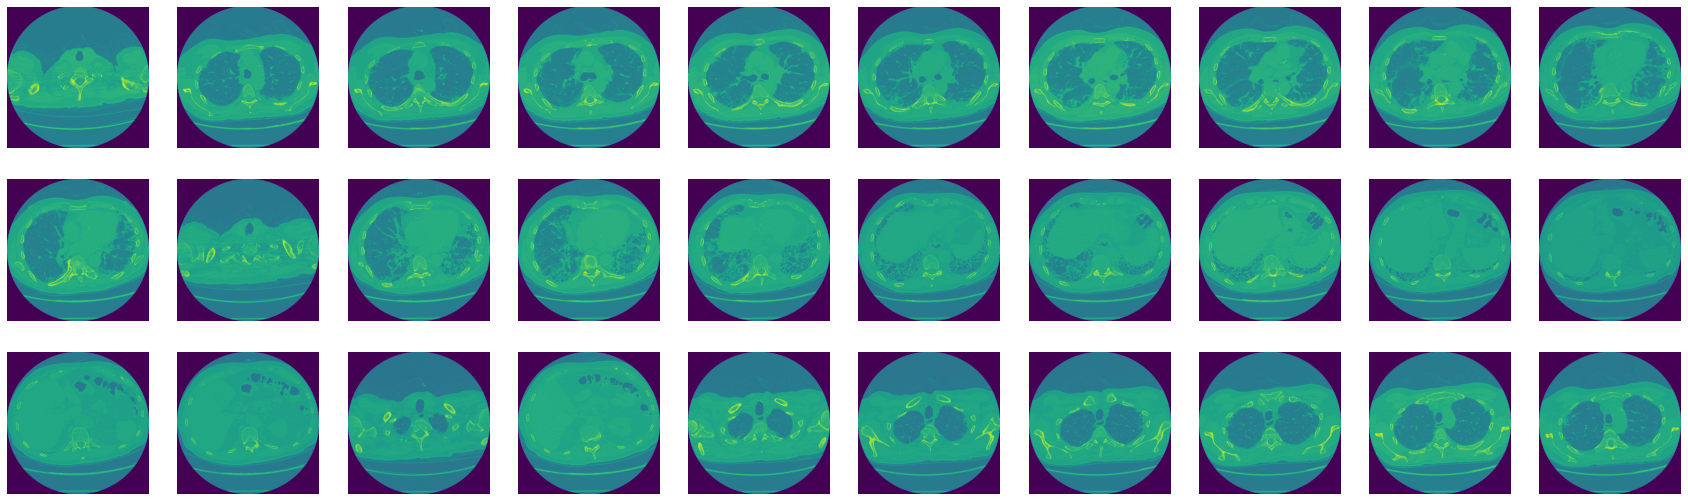

In [12]:
%%time
imgs = []
for filename in sort_items:
    file = dcmread(filename).pixel_array
    img = TensorDicom(file)
    imgs.append(img)
show_images(imgs, nrows=3)

Wall time: 572 ms


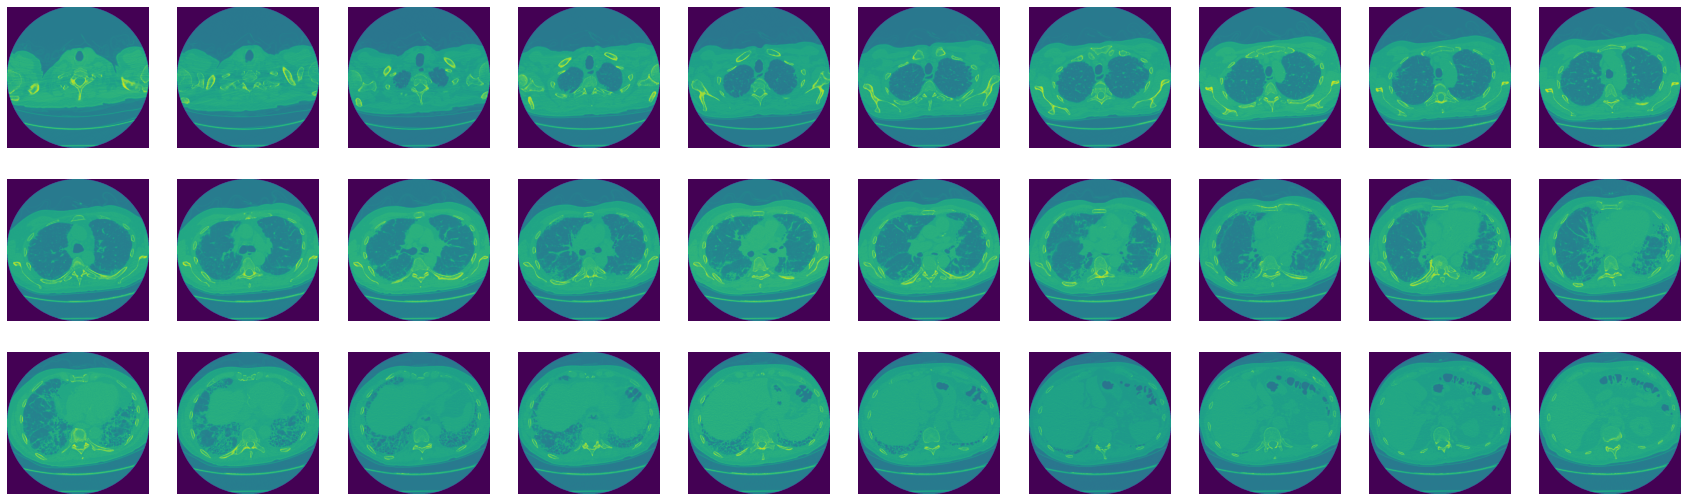

In [13]:
%%time
instance_show(sort_items, nrows=3)

## Mask and Save

In [14]:
m_items = get_dicom_files('D:/Datasets/osic-pulmonary-fibrosis-progression/train/ID00007637202177411956430')
source = 'D:/Datasets/osic-pulmonary-fibrosis-progression/train/'
dicom_dataframe = pd.DataFrame.from_dicoms(m_items)
dicom_dataframe[:2]

SpecificCharacterSet ImageType                               SOPInstanceUID  \
0           ISO_IR 100  ORIGINAL  2.25.12297650151329871895440507938349160734   
1           ISO_IR 100  ORIGINAL  2.25.37611372879908126511187998276199853341   

  Modality        Manufacturer ManufacturerModelName  \
0       CT  GE MEDICAL SYSTEMS        LightSpeed VCT   
1       CT  GE MEDICAL SYSTEMS        LightSpeed VCT   

                                                                   PatientName  \
0  (I, D, 0, 0, 0, 0, 7, 6, 3, 7, 2, 0, 2, 1, 7, 7, 4, 1, 1, 9, 5, 6, 4, 3, 0)   
1  (I, D, 0, 0, 0, 0, 7, 6, 3, 7, 2, 0, 2, 1, 7, 7, 4, 1, 1, 9, 5, 6, 4, 3, 0)   

                   PatientID PatientSex DeidentificationMethod  ...  \
0  ID00007637202177411956430                            Table;  ...   
1  ID00007637202177411956430                            Table;  ...   

  ImageOrientationPatient3  ImageOrientationPatient4  \
0                      0.0                       1.0   
1                      0.0                       1.0   

   ImageOrientationPatient5  MultiPixelSpacing  PixelSpacing1  img_min  \
0                       0.0                  1       0.652344    -2000   
1                       0.0                  1       0.652344    -2000   

   img_max   img_mean      img_std  img_pct_window  
0     2842  -1.454884  1137.488858        0.058094  
1     2918  19.038597  1138.876560        0.068130  

[2 rows x 67 columns]

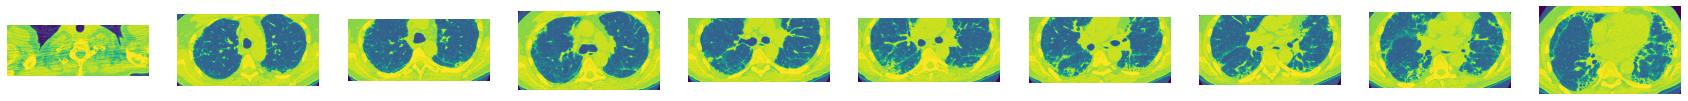

In [15]:
#sigma 0.2
mask_and_save(dicom_dataframe[:20], show=True, source=source, sigma=0.2, save=False)

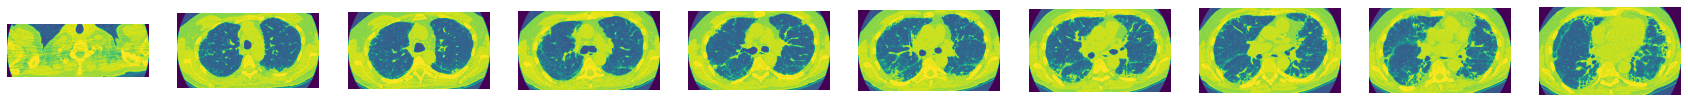

In [16]:
#sigma 0.1
mask_and_save(dicom_dataframe[:20], show=True, source=source, sigma=0.1, save=False)

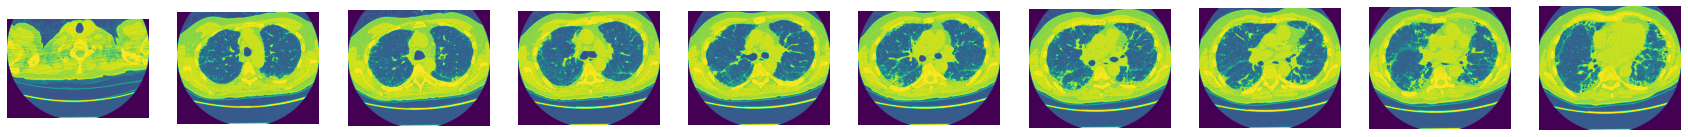

In [17]:
#sigma 0.01
mask_and_save(dicom_dataframe[:20], show=True, source=source, sigma=0.01, save=False)

## pct_window, mean, std

In [18]:
pct = dicom_dataframe[['PatientID', 'InstanceNumber', 'img_pct_window', 'img_mean', 'img_std']].sort_values(by=['img_pct_window'], ascending=False).reset_index(drop=True)
pct[:5]

PatientID  InstanceNumber  img_pct_window    img_mean  \
0  ID00007637202177411956430              20        0.077923  109.478535   
1  ID00007637202177411956430              21        0.075516  127.095284   
2  ID00007637202177411956430              29        0.075508  210.377762   
3  ID00007637202177411956430              18        0.075157   97.442841   
4  ID00007637202177411956430              28        0.075096  212.950813   

       img_std  
0  1174.014672  
1  1182.195403  
2  1217.328780  
3  1172.540524  
4  1219.356338

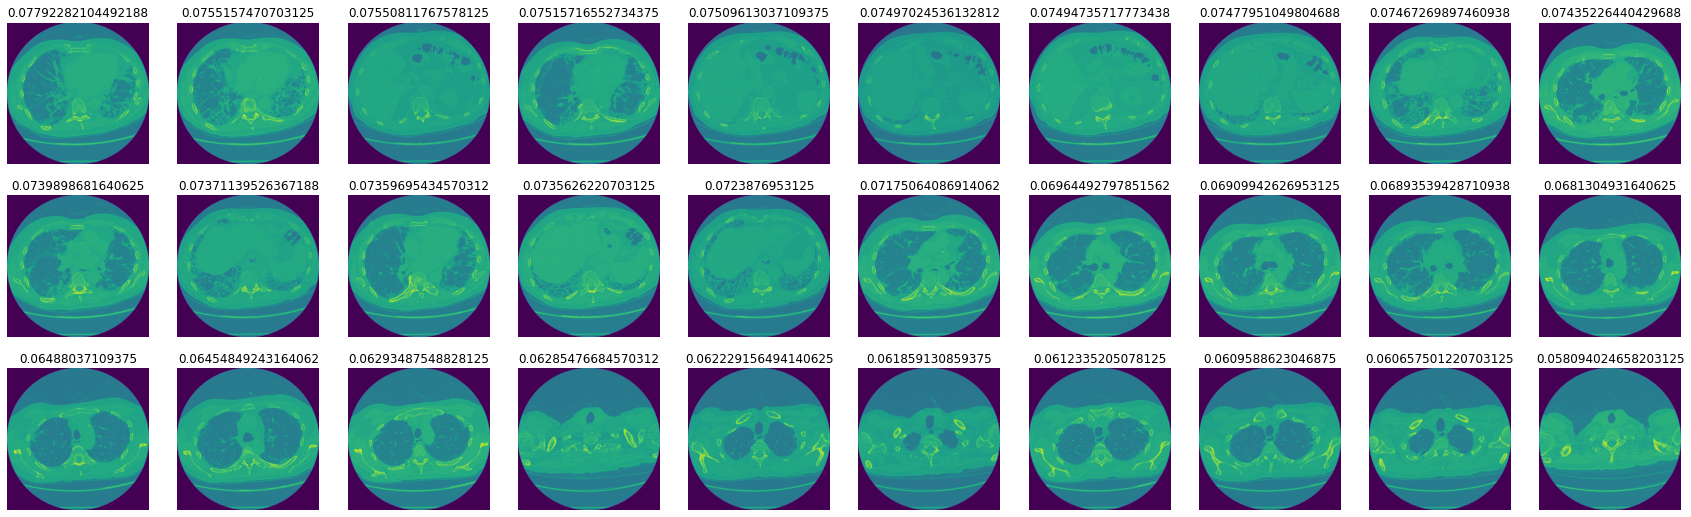

In [19]:
get_dicom_image(pct[:30], 'img_pct_window', source=source) 

In [20]:
mean = dicom_dataframe[['PatientID', 'InstanceNumber', 'img_pct_window', 'img_mean', 'img_std']].sort_values(by=['img_mean'], ascending=True).reset_index(drop=True)
mean[:5]

PatientID  InstanceNumber  img_pct_window   img_mean  \
0  ID00007637202177411956430               1        0.058094  -1.454884   
1  ID00007637202177411956430              10        0.068130  19.038597   
2  ID00007637202177411956430               9        0.064880  25.004814   
3  ID00007637202177411956430              11        0.064548  27.237549   
4  ID00007637202177411956430               8        0.062935  29.426968   

       img_std  
0  1137.488858  
1  1138.876560  
2  1146.082668  
3  1146.816206  
4  1150.758986

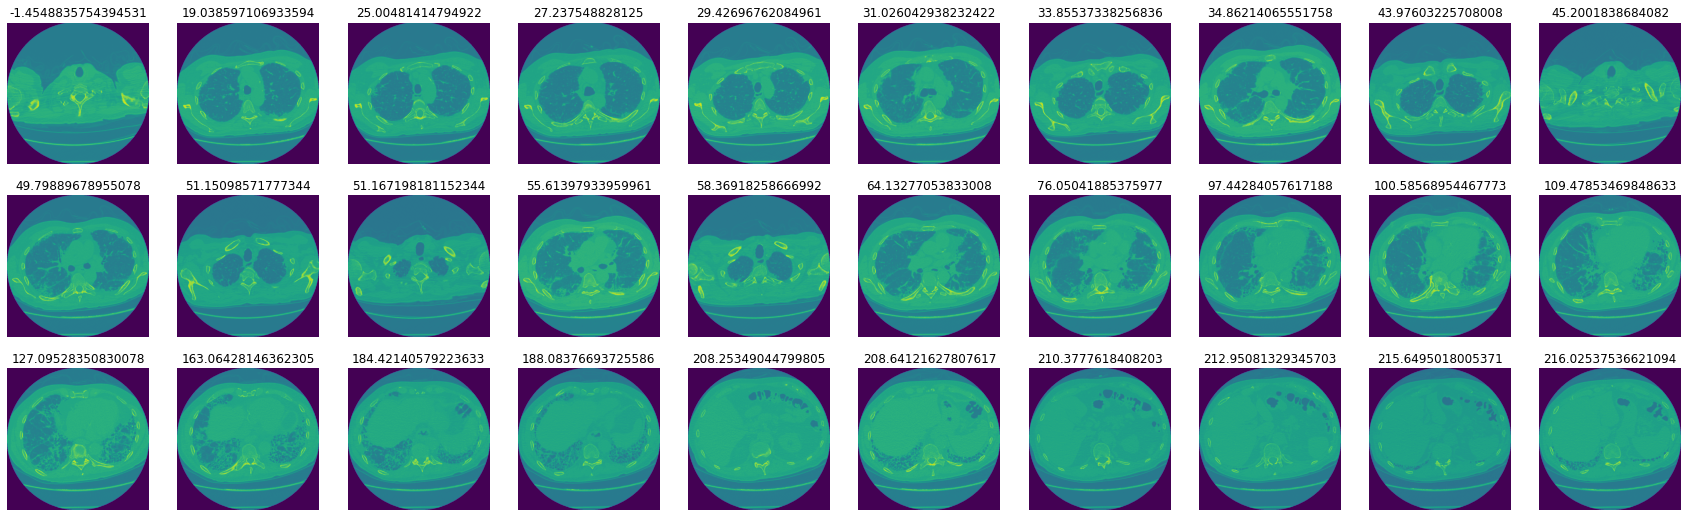

In [21]:
get_dicom_image(mean[:30], 'img_mean', source=source) 

In [22]:
std = dicom_dataframe[['PatientID', 'InstanceNumber', 'img_pct_window', 'img_mean', 'img_std']].sort_values(by=['img_std'], ascending=True).reset_index(drop=True)
std[:5]

PatientID  InstanceNumber  img_pct_window   img_mean  \
0  ID00007637202177411956430               1        0.058094  -1.454884   
1  ID00007637202177411956430              10        0.068130  19.038597   
2  ID00007637202177411956430              12        0.069099  31.026043   
3  ID00007637202177411956430               9        0.064880  25.004814   
4  ID00007637202177411956430              11        0.064548  27.237549   

       img_std  
0  1137.488858  
1  1138.876560  
2  1142.850763  
3  1146.082668  
4  1146.816206

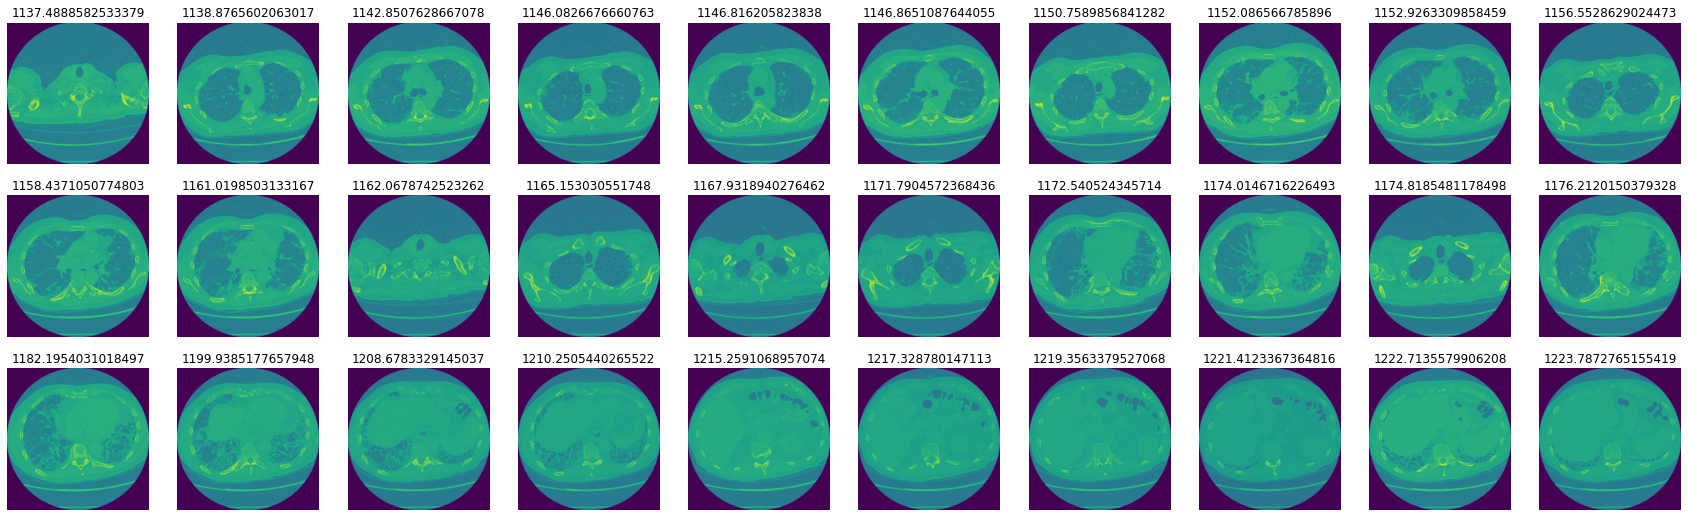

In [23]:
get_dicom_image(std[:30], 'img_std', source=source) 

## Metadata dict

In [24]:
dicom_dataframe = pd.DataFrame.from_dicoms2(test_files, windows=dicom_windows.mediastinum)
dicom_dataframe[:2]

SpecificCharacterSet  \
0  [ISO 2022 IR 100, ISO 2022 IR 100]   
1  [ISO 2022 IR 100, ISO 2022 IR 100]   

                                  ImageType  \
0  [DERIVED, SECONDARY, AXIAL, CT_SOM5 SPI]   
1  [DERIVED, SECONDARY, AXIAL, CT_SOM5 SPI]   

                                      SOPInstanceUID Modality Manufacturer  \
0  1.2.276.0.7230010.3.1.4.0.37492.1591423150.182195       CT      SIEMENS   
1  1.2.276.0.7230010.3.1.4.0.37492.1591423150.182204       CT      SIEMENS   

  ManufacturerModelName  \
0                OsiriX   
1                OsiriX   

                                                                   PatientName  \
0  (I, D, 0, 0, 0, 0, 9, 6, 3, 7, 2, 0, 2, 1, 7, 7, 4, 3, 4, 4, 7, 6, 2, 7, 8)   
1  (I, D, 0, 0, 0, 0, 9, 6, 3, 7, 2, 0, 2, 1, 7, 7, 4, 3, 4, 4, 7, 6, 2, 7, 8)   

                   PatientID PatientSex DeidentificationMethod  ...  \
0  ID00009637202177434476278                            Table;  ...   
1  ID00009637202177434476278                            Table;  ...   

  WindowWidth  RescaleIntercept  RescaleSlope  RescaleType  img_min  img_max  \
0      1500.0           -1024.0           1.0           HU        0     4573   
1      1500.0           -1024.0           1.0           HU        0     4346   

     img_mean     img_std  img_pct_window                         file_path  
0  571.728331  568.734741        0.216307   ID00009637202177434476278/1.dcm  
1  591.064126  568.077568        0.217928  ID00009637202177434476278/10.dcm  

[2 rows x 52 columns]

In [25]:
dicom_dataframe = pd.DataFrame.from_dicoms2(test_files, windows=dicom_windows.lungs)
dicom_dataframe[:2]

SpecificCharacterSet  \
0  [ISO 2022 IR 100, ISO 2022 IR 100]   
1  [ISO 2022 IR 100, ISO 2022 IR 100]   

                                  ImageType  \
0  [DERIVED, SECONDARY, AXIAL, CT_SOM5 SPI]   
1  [DERIVED, SECONDARY, AXIAL, CT_SOM5 SPI]   

                                      SOPInstanceUID Modality Manufacturer  \
0  1.2.276.0.7230010.3.1.4.0.37492.1591423150.182195       CT      SIEMENS   
1  1.2.276.0.7230010.3.1.4.0.37492.1591423150.182204       CT      SIEMENS   

  ManufacturerModelName  \
0                OsiriX   
1                OsiriX   

                                                                   PatientName  \
0  (I, D, 0, 0, 0, 0, 9, 6, 3, 7, 2, 0, 2, 1, 7, 7, 4, 3, 4, 4, 7, 6, 2, 7, 8)   
1  (I, D, 0, 0, 0, 0, 9, 6, 3, 7, 2, 0, 2, 1, 7, 7, 4, 3, 4, 4, 7, 6, 2, 7, 8)   

                   PatientID PatientSex DeidentificationMethod  ...  \
0  ID00009637202177434476278                            Table;  ...   
1  ID00009637202177434476278                            Table;  ...   

  WindowWidth  RescaleIntercept  RescaleSlope  RescaleType  img_min  img_max  \
0      1500.0           -1024.0           1.0           HU        0     4573   
1      1500.0           -1024.0           1.0           HU        0     4346   

     img_mean     img_std  img_pct_window                         file_path  
0  571.728331  568.734741        0.851178   ID00009637202177434476278/1.dcm  
1  591.064126  568.077568        0.843967  ID00009637202177434476278/10.dcm  

[2 rows x 52 columns]

### Convert to 3 channel

In [26]:
save_dir = 'D:/Datasets/osic-pulmonary-fibrosis-progression/test3c/'
test1 = test_files[12]
test1

Path('D:/Datasets/osic-pulmonary-fibrosis-progression/train/ID00009637202177434476278/11.dcm')

In [27]:
dicom_convert_3channel(test1, save_dir, win1=dicom_windows.lungs, win2=dicom_windows.mediastinum, win3=dicom_windows.pe)

Test saved image

In [28]:
saved_image = PILImage.create('D:/Datasets/osic-pulmonary-fibrosis-progression/test3c/11.jpg')
saved_ten = TensorImage(saved_image)
saved_ten.shape

torch.Size([768, 768, 3])

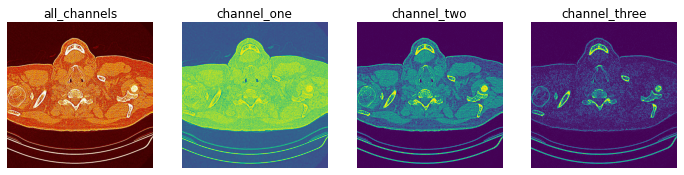

In [29]:
show_images([saved_ten[:,:,:], saved_ten[:,:,0], saved_ten[:,:,1], saved_ten[:,:,2]],\
            titles=['all_channels', 'channel_one', 'channel_two', 'channel_three'])